Credit : https://keras.io/examples/vision/deeplabv3_plus/

In [1]:
import tensorflow as tf 
from tensorflow.keras import layers

import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from glob import glob
from scipy.io import loadmat

In [2]:
#!gdown "1B9A9UCJYMwTL4oBEo4RZfbMZMaZhKJaz&confirm=t"
#!unzip -q instance-level-human-parsing.zip

In [2]:
image_size = 512
batch_size = 4
num_classes = 20 
#data_dir = "./instance-level_human_parsing/instance-level_human_parsing/Training"
data_dir = "D:\Bangkit 2023\Capstone\ML_Model-main\instance-level-human-parsing\instance-level_human_parsing\instance-level_human_parsing\Training"
num_train = 500
num_val = 20

train_images = sorted(glob(os.path.join(data_dir, "Images/*")))[:num_train]
train_masks = sorted(glob(os.path.join(data_dir, "Category_ids/*")))[:num_train]
val_images = sorted(glob(os.path.join(data_dir, "Images/*")))[num_train : num_val + num_train]
val_masks = sorted(glob(os.path.join(data_dir, "Category_ids/*")))[num_train : num_val + num_train]

def read_img(img_path, mask=False):
    image = tf.io.read_file(img_path)
    if mask:
        image = tf.image.decode_png(image, channels=1) #b&w output
        image.set_shape([None, None, 1]) 
        image = tf.image.resize(images=image, size=[image_size, image_size])
    else:
        image = tf.image.decode_png(image, channels=3) #rgb output
        image.set_shape([None, None, 3])
        image = tf.image.resize(images=image, size=[image_size, image_size])
        image = tf.keras.applications.resnet50.preprocess_input(image)
    return image

def load_data(img_list, mask_list):
    image = read_img(img_list)
    mask = read_img(mask_list, mask=True)
    return image, mask

def data_generator(img_list, mask_list):
    dataset = tf.data.Dataset.from_tensor_slices((img_list, mask_list))
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    return dataset

train_dataset = data_generator(train_images, train_masks)
val_dataset = data_generator(val_images, val_masks)

print("Train Dataset:", train_dataset)
print("Validation Dataset:", val_dataset)




Train Dataset: <_BatchDataset element_spec=(TensorSpec(shape=(4, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(4, 512, 512, 1), dtype=tf.float32, name=None))>
Validation Dataset: <_BatchDataset element_spec=(TensorSpec(shape=(4, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(4, 512, 512, 1), dtype=tf.float32, name=None))>


In [3]:
def conv_block(block_input, num_filters=64, kernel_size=1):
    x = tf.keras.layers.Conv2D(
        num_filters, 
        kernel_size=kernel_size,
        padding="same",
        use_bias=False,
        kernel_initializer= tf.keras.initializers.HeNormal()
    )(block_input)
    x = layers.BatchNormalization()(x)
    return tf.nn.relu(x)

In [4]:
def DilatatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = tf.keras.layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = conv_block(x)
    out_pool = tf.keras.layers.UpSampling2D(
        size = (dims[-3] // x.shape[1], dims[-2] // x.shape[2]), interpolation="bilinear",
    )(x)

    out = conv_block(dspp_input)

    x = tf.keras.layers.Concatenate(axis=-1)([out_pool, out])
    output = conv_block(x)
    return output

In [5]:
def DeepLabV3Plus(image_size, num_classes):
    model_input = tf.keras.Input(shape=(image_size, image_size, 3))

    resnet50 = tf.keras.applications.ResNet50(
        weights="imagenet", include_top=False, input_tensor=model_input
    )
    x = resnet50.get_layer("conv4_block6_2_relu").output
    x = DilatatedSpatialPyramidPooling(x)

    input_1 = tf.keras.layers.UpSampling2D(
        size = (image_size // 4 // x.shape[1], image_size // 4 // x.shape[2]),
        interpolation="bilinear"
    )(x)
    input_2 = resnet50.get_layer("conv2_block3_2_relu").output
    input_2 = conv_block(input_2, num_filters=48)

    x = tf.keras.layers.Concatenate(axis=-1)([input_1, input_2])
    x = conv_block(x)
    x = layers.UpSampling2D(
        size=(image_size // x.shape[1], image_size // x.shape[2]),
        interpolation="bilinear"
    )(x)
    model_output = tf.keras.layers.Conv2D(num_classes, kernel_size=(1,1), padding="same")(x)
    return tf.keras.Model(inputs=model_input, outputs=model_output)

model = DeepLabV3Plus(image_size=image_size, num_classes=num_classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 518, 518, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 256, 256, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [6]:
class myCallback(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs={}):
            if logs.get('accuracy') > 0.95:                 
                print("\nReached 95% accuracy so cancelling training!")
                
                self.model.stop_training = True

Epoch 1/25
125/125 [==============================] - 633s 5s/step - loss: 2.4901 - accuracy: 0.3245 - val_loss: 2.6384 - val_accuracy: 0.3538
Epoch 2/25
125/125 [==============================] - 620s 5s/step - loss: 1.6674 - accuracy: 0.6496 - val_loss: 1.5459 - val_accuracy: 0.6972
Epoch 3/25
125/125 [==============================] - 618s 5s/step - loss: 1.2448 - accuracy: 0.7450 - val_loss: 1.2409 - val_accuracy: 0.7268
Epoch 4/25
125/125 [==============================] - 737s 6s/step - loss: 0.9815 - accuracy: 0.7908 - val_loss: 1.1068 - val_accuracy: 0.7413
Epoch 5/25
125/125 [==============================] - 702s 6s/step - loss: 0.8191 - accuracy: 0.8199 - val_loss: 1.1071 - val_accuracy: 0.7180
Epoch 6/25
125/125 [==============================] - 679s 5s/step - loss: 0.7220 - accuracy: 0.8363 - val_loss: 0.9806 - val_accuracy: 0.7618
Epoch 7/25
125/125 [==============================] - 700s 6s/step - loss: 0.6410 - accuracy: 0.8519 - val_loss: 1.0304 - val_accuracy: 0.7282

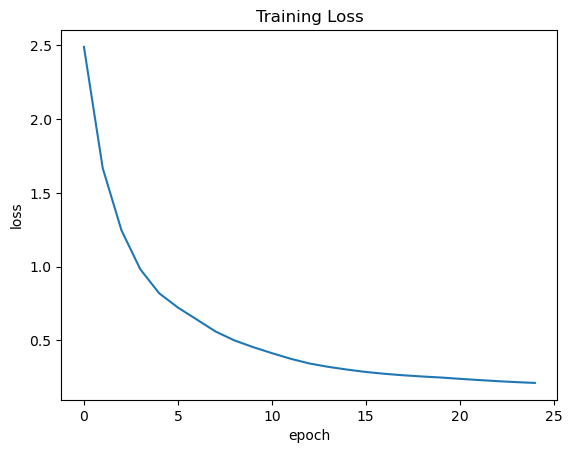

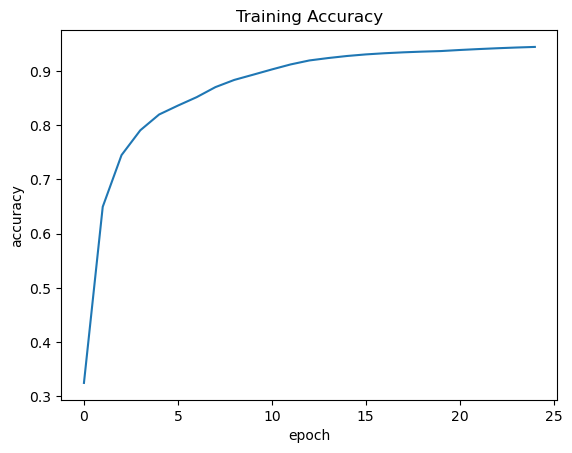

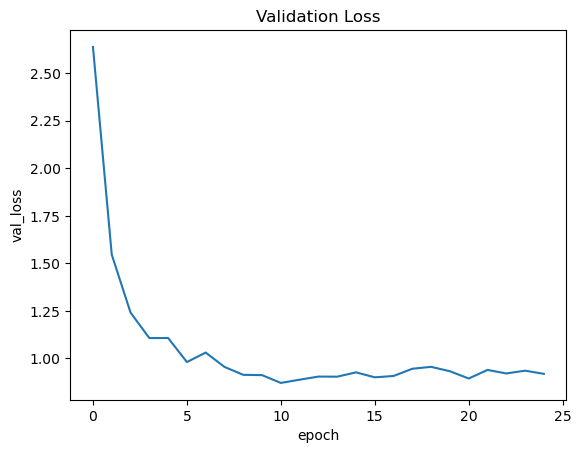

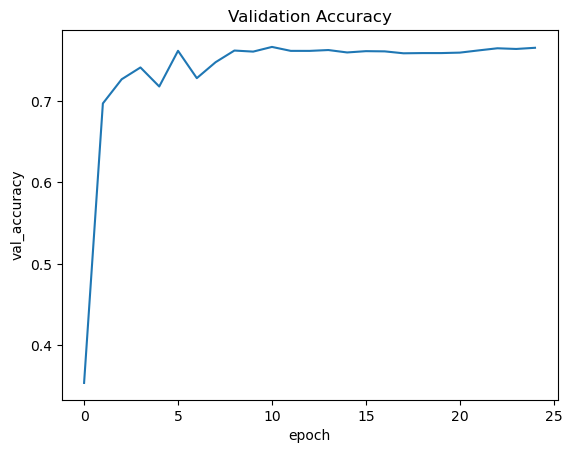

In [7]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
callbacks = myCallback()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=loss,
    metrics=["accuracy"]
)

history = model.fit(train_dataset, validation_data = val_dataset, epochs=25, callbacks=[callbacks])

plt.plot(history.history["loss"])
plt.title("Training Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["accuracy"])
plt.title("Training Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_loss"])
plt.title("Validation Loss")
plt.ylabel("val_loss")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_accuracy"])
plt.title("Validation Accuracy")
plt.ylabel("val_accuracy")
plt.xlabel("epoch")
plt.show()